# K-means segmentation

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

import helper as h

In [21]:
_data = h.get_merged_data('k-means', year=2016)
cols = _data.columns

_data.head()

% of users dropped 4.698526359485271


Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at='2011-05-24 20:15:25+00:00', public_repos_count=7, public_gists_count=0, hireable=1, updated_at='2019-01-09 15:03:59+00:00', time_between_first_last_event='10 days 15:29:06.000000000', last_event='2016-04-15 10:14:03 UTC', first_event='2016-04-04 18:44:57 UTC', frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0)

In [56]:
churn_data = _data.filter(_data.company == 0) 

## Create new features

1. Active events.
2. Public repos and gists

Take the log of each of these.

In [57]:
churn_data = h.create_KMeans_features(churn_data)

In [58]:
churn_data.select(['non_passive_events', 'public_repos_gists']).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
non_passive_events,155008,2.04122051765903,1.156216858085956,0.0,5.298317366548036
public_repos_gists,141935,2.519910756023042,1.2686131067841777,1.0,8.69575799055476


In [59]:
stages = [VectorAssembler(inputCols=['non_passive_events', 'public_repos_gists'], 
                            outputCol="KMeans_features").setHandleInvalid("skip")]

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(churn_data)
churn_data = pipelineModel.transform(churn_data)
selectedCols = ['label', 'features'] + cols
#churn_data = churn_data.select(selectedCols)
churn_data.printSchema()

root
 |-- login: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- blog: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- public_repos_count: integer (nullable = true)
 |-- public_gists_count: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- time_between_first_last_event: string (nullable = true)
 |-- last_event: string (nullable = true)
 |-- first_event: string (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- second_period_event_count: integer (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer (nullable = true)
 |-- IssueCommentEvent_count: integer (nullable = true)
 

In [60]:
churn_data.head()

Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at='2011-05-24 20:15:25+00:00', public_repos_count=7, public_gists_count=0, hireable=1, updated_at='2019-01-09 15:03:59+00:00', time_between_first_last_event='10 days 15:29:06.000000000', last_event='2016-04-15 10:14:03 UTC', first_event='2016-04-04 18:44:57 UTC', frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0, non_passive_events=2.995732273553991, public_repos_gists=2.9459101490553135, KMeans_features=DenseVector([2.9957, 2.9459]))

In [61]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='KMeans_features', 
                predictionCol='high_low_user').setK(2).setSeed(1)
model = kmeans.fit(churn_data)

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(churn_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 214014.34694256188
Cluster Centers: 
[1.47716011 1.65329398]
[2.85952128 3.59690319]


In [62]:
model.write().overwrite().save('KMeans_model')

In [52]:
predictions = model.transform(churn_data)

In [53]:
predictions_df = predictions.toPandas()

Text(0, 0.5, 'Log # of active events')

/home/brian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


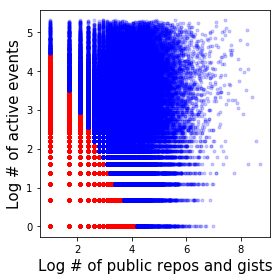

In [54]:
fsize=15
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fig.set_tight_layout(True)

ax.plot(predictions_df.public_repos_gists.values[predictions_df.prediction.values == 0], 
        predictions_df.non_passive_events.values[predictions_df.prediction.values == 0], 
               'r.', alpha=0.2)

ax.plot(predictions_df.public_repos_gists.values[predictions_df.prediction.values == 1], 
        predictions_df.non_passive_events.values[predictions_df.prediction.values == 1], 
               'b.', alpha=0.2)

ax.set_xlabel('Log # of public repos and gists', fontsize=fsize)
ax.set_ylabel('Log # of active events', fontsize=fsize)

In [55]:
print('{0}% labels == 0'.format(np.round(np.sum(
    predictions_df.prediction == 0) / len(predictions_df.prediction) * 100, 2)))

55.41% labels == 0


In [63]:
predictions = model.transform(churn_data)

In [69]:
predictions.toPandas()

,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,updated_at,...,PublicEvent_count,PullRequestEvent_count,PullRequestReviewCommentEvent_count,PushEvent_count,ReleaseEvent_count,WatchEvent_count,non_passive_events,public_repos_gists,KMeans_features,high_low_user
0,0loky0,0,1,0,0,2011-05-24 20:15:25+00:00,7,0,1,2019-01-09 15:03:59+00:00,...,0,0,0,12,0,0,2.995732,2.945910,"[2.995732273553991, 2.9459101490553135]",1
1,13246864965,0,0,0,0,2016-04-14 10:04:50+00:00,3,0,0,2018-08-02 07:48:44+00:00,...,0,0,0,1,0,0,1.386294,2.098612,"[1.3862943611198906, 2.09861228866811]",0
2,2582056905xy,2,6,0,0,2014-04-24 14:51:26+00:00,35,0,0,2018-10-18 01:47:18+00:00,...,0,1,0,2,0,2,2.302585,4.555348,"[2.302585092994046, 4.555348061489413]",1
3,277542952,1,28,0,0,2016-03-16 03:17:58+00:00,1,0,0,2017-08-14 19:48:16+00:00,...,0,0,0,0,0,12,1.098612,1.000000,"[1.0986122886681098, 1.0]",0
4,353764437,0,0,0,0,2016-02-17 07:40:15+00:00,2,0,0,2017-10-26 02:54:12+00:00,...,0,0,0,0,0,0,1.609438,1.693147,"[1.6094379124341003, 1.6931471805599454]",0
5,AJ340,3,6,1,0,2016-04-15 18:12:45+00:00,17,0,0,2019-01-07 16:25:43+00:00,...,0,0,0,21,0,0,3.737670,3.833213,"[3.7376696182833684, 3.833213344056216]",1
6,AaronWB,3,0,1,0,2014-02-11 15:03:04+00:00,25,1,0,2019-01-20 11:57:00+00:00,...,0,0,0,0,0,1,0.693147,4.258097,"[0.6931471805599453, 4.258096538021482]",1
7,Aarteaga102,0,0,0,0,2015-09-15 19:59:26+00:00,6,0,0,2016-09-22 19:50:02+00:00,...,0,0,0,6,0,0,1.945910,2.791759,"[1.9459101490553132, 2.791759469228055]",1
8,Abberbex,1,0,0,0,2011-12-06 22:19:40+00:00,2,0,0,2016-02-22 08:37:04+00:00,...,0,0,0,0,0,0,1.609438,1.693147,"[1.6094379124341003, 1.6931471805599454]",0
9,AbdulRafay,0,2,1,0,2011-02-12 20:59:57+00:00,5,0,1,2018-11-29 23:30:15+00:00,...,0,0,0,1,0,0,1.945910,2.609438,"[1.9459101490553132, 2.6094379124341005]",0
